In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", palette="dark")

# Machine learning libraries
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder

# Resampling libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Art Garfunkel's Favorite Books

The dataset I am using to day is [Art Garfunkels's Library](https://www.kaggle.com/datasets/chrico03/art-garfunkels-library). Art Garfunkel is an American singer best known for his hit act with Paul Simon - Simon & Garfunkel. Ever since the 1970s, he has been recording the books he collects and reads over the years on his website. I will be using the prepared dataset of his '[Library](https://www.artgarfunkel.com/)' to try and predict which of the 1000+ books in his library are likely to be his favorite.

In [2]:
library_df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")
library_df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


## Data Exploration & Cleaning
First, I will get the data into a format which I find more usable for my purposes.
- The 'Date Read' column can be broken up into two separate columns - 'Month Read' and 'Year Read'. It may be worth it to try encoding months as either numerical and categorical features.
- The 'Year Published" column has a wide range of dates, some of which may be difficult to process (ie. "10,000 B.C."). Python is not great at handling these kinds of dates well, even using the datetime module. You can read more about it [here](https://realpython.com/lessons/messy-date-time/#transcript). So I will be replacing the values in these rows with 'nan' values with the intention of backfilling missing data with an imputer.


In [3]:
months = dict(Jan=1,Feb=2,Mar=3,Apr=4,May=5,Jun=6,Jul=7,Aug=8,Sep=9,Oct=10,Nov=11,Dec=12)

def get_month_from_date_read_column(date, to_numeric=True):
    month_date_split = date.split('-')
    
    if len(month_date_split) == 2:
        if to_numeric == True:
            return int(months[month_date_split[0]])
        else:
            return month_date_split[0]
    else:
        return np.nan


def get_year_from_date_read_column(date):
    year_date_split = date.split('-')
    if len(year_date_split) == 2:
        year = int(year_date_split[1])
        if year < 41: # FUN FACT: Art's Year of Birth: 1941
            return int(2000+year)
        else :
            return int(1900+year)
    else:
        return np.nan    

In [4]:
library_df['Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date))
library_df['Cat_Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date,False))
  
library_df['Year Read'] = library_df['Date Read'].apply(lambda date: get_year_from_date_read_column(date))
library_df['Decade Read'] = library_df['Year Read'].apply(lambda y: np.floor(y/10)*10)

In [5]:
library_df['Year Published'] = library_df['Year Published'].apply(lambda year: np.nan if (len(year) != 4 or str(year[-1]).isalpha()) else year)

# Encoding cyclical features (hour, month, year, etc.)
library_df['cos_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)
library_df['sin_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)

In [6]:
def get_author_count(authors):
    authors = authors.split(',')
    skips = [' M.D.', ' Jr.', 'editor', ' ed.' ]
    for author in authors:
        if author in skips:
            authors.remove(author)
    return len(authors)

def get_single_author(author):
    if author == 'Various':
        return np.nan
    return 1

In [7]:
library_df['Words in Title'] = library_df.Books.apply(lambda b: len(b.split()))

library_df['Surname Length'] = library_df.Author.apply(lambda a: len(a.split()[-1].replace('-', '')))
library_df['Author Count'] = library_df.Author.apply(lambda a: get_single_author(a) if len(a.split(','))==1 else get_author_count(a)).sort_values()

## Exploratory Analysis
Now we can look at the data to determine which features can be used for the analysis and/or feature enginering. I decided not to use features 'Author' or 'Books' directly because of thier high number of unique entries relative to the total size of the dataset. Instead, I opted to create a series of numerical features to better describe these textual data columns.

In [8]:
library_df.drop(columns=['cos_Month Read', 'sin_Month Read']).describe(percentiles=[])

,Pages,Favorite,Month Read,Year Read,Decade Read,Words in Title,Surname Length,Author Count
count,1321.000000,1321.000000,1196.000000,1196.000000,1196.000000,1321.000000,1321.000000,1314.000000
mean,313.020439,0.102952,6.745819,1993.517559,1989.046823,3.669190,6.582135,1.029680
std,191.174830,0.304012,3.471429,13.164890,13.645646,2.078832,1.826849,0.220507
min,13.000000,0.000000,1.000000,1968.000000,1960.000000,1.000000,2.000000,1.000000
50%,275.000000,0.000000,7.000000,1992.000000,1990.000000,3.000000,6.000000,1.000000
max,1664.000000,1.000000,12.000000,2022.000000,2020.000000,15.000000,14.000000,4.000000


Here, we can look at the target feature. The target column for this dataset is 'Favorite'; there's a big imbalance between the number of non-favorite vs. favorite books, which affects how we will approach our analysis.

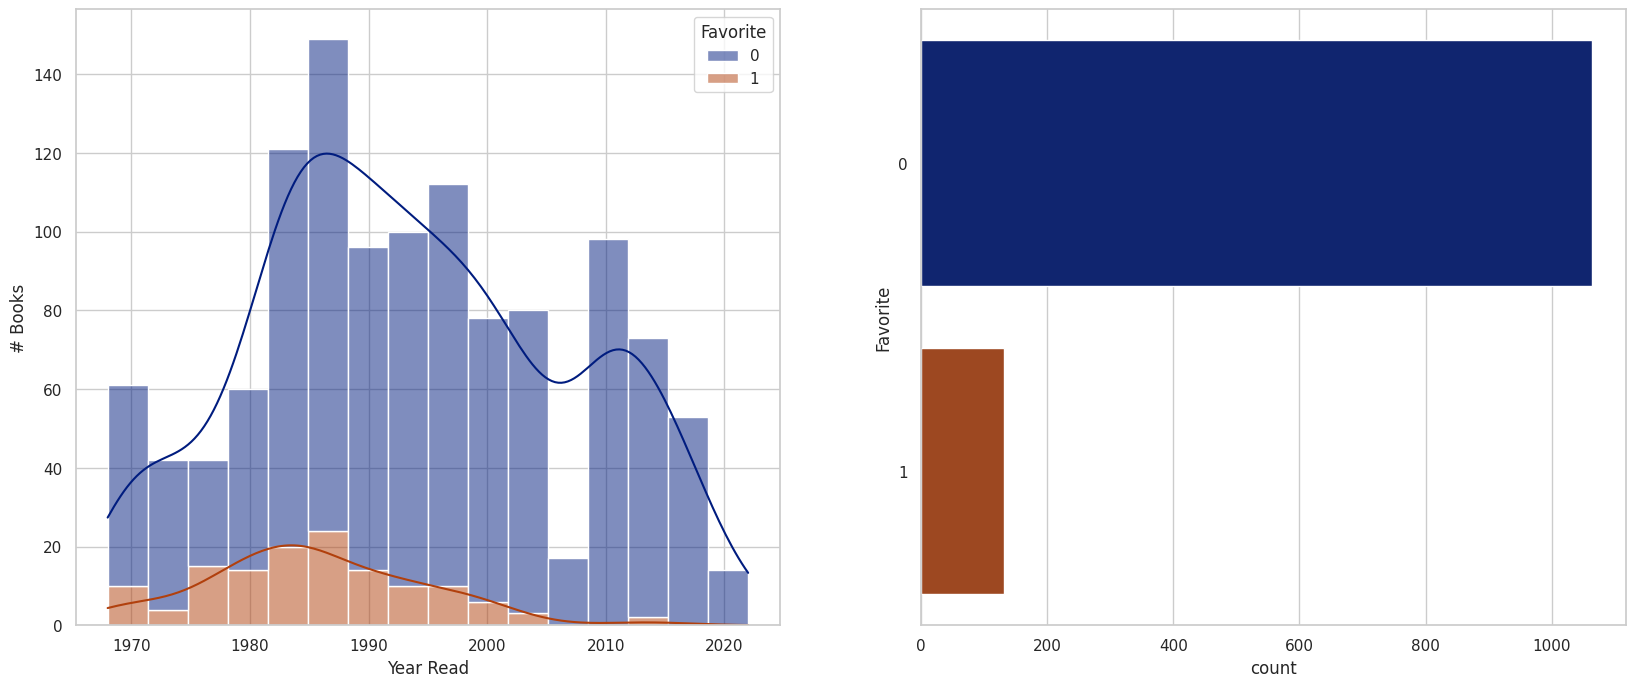

In [9]:
books_per_year = library_df._get_numeric_data().groupby('Year Read').count()['Pages'].reset_index()
books_per_year = books_per_year.rename({'Pages':'Books Per Year'}, axis=1)
library_df = library_df.merge(books_per_year, on='Year Read')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Year Read")
ax1.set_ylabel("# Books")

sns.histplot(data=library_df, x="Year Read", hue='Favorite', kde=True, multiple='stack', ax=ax1)
sns.countplot(y=library_df['Favorite'],data=library_df, ax=ax2)
plt.show()

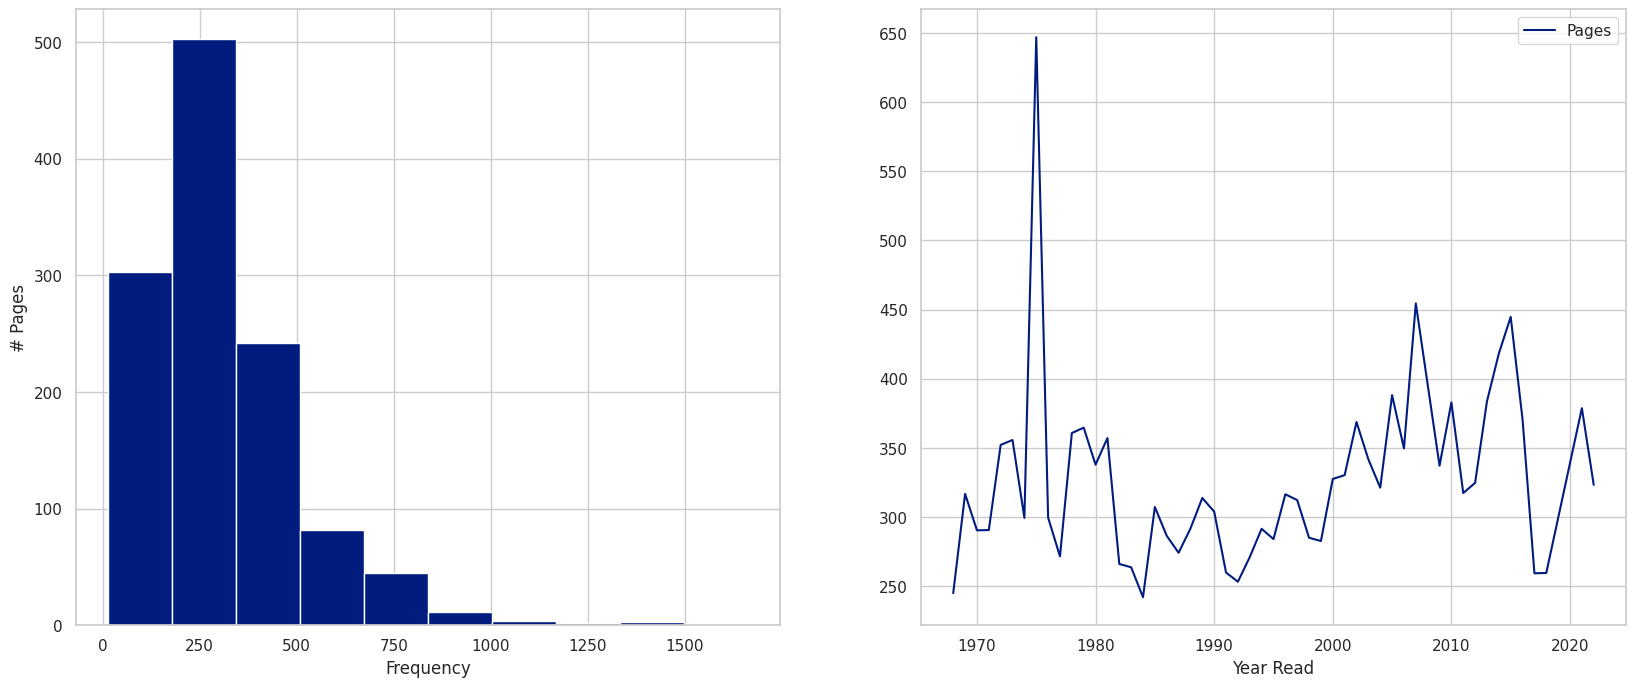

In [10]:
pages_per_year = library_df[['Year Read', 'Pages']].groupby(['Year Read']).mean()
library_df = library_df.merge(pages_per_year, on='Year Read', suffixes=['', ' Per Year'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Frequency")
ax1.set_ylabel("# Pages")

library_df['Pages'].hist(ax=ax1)
sns.lineplot(pages_per_year, ax=ax2)
plt.show()

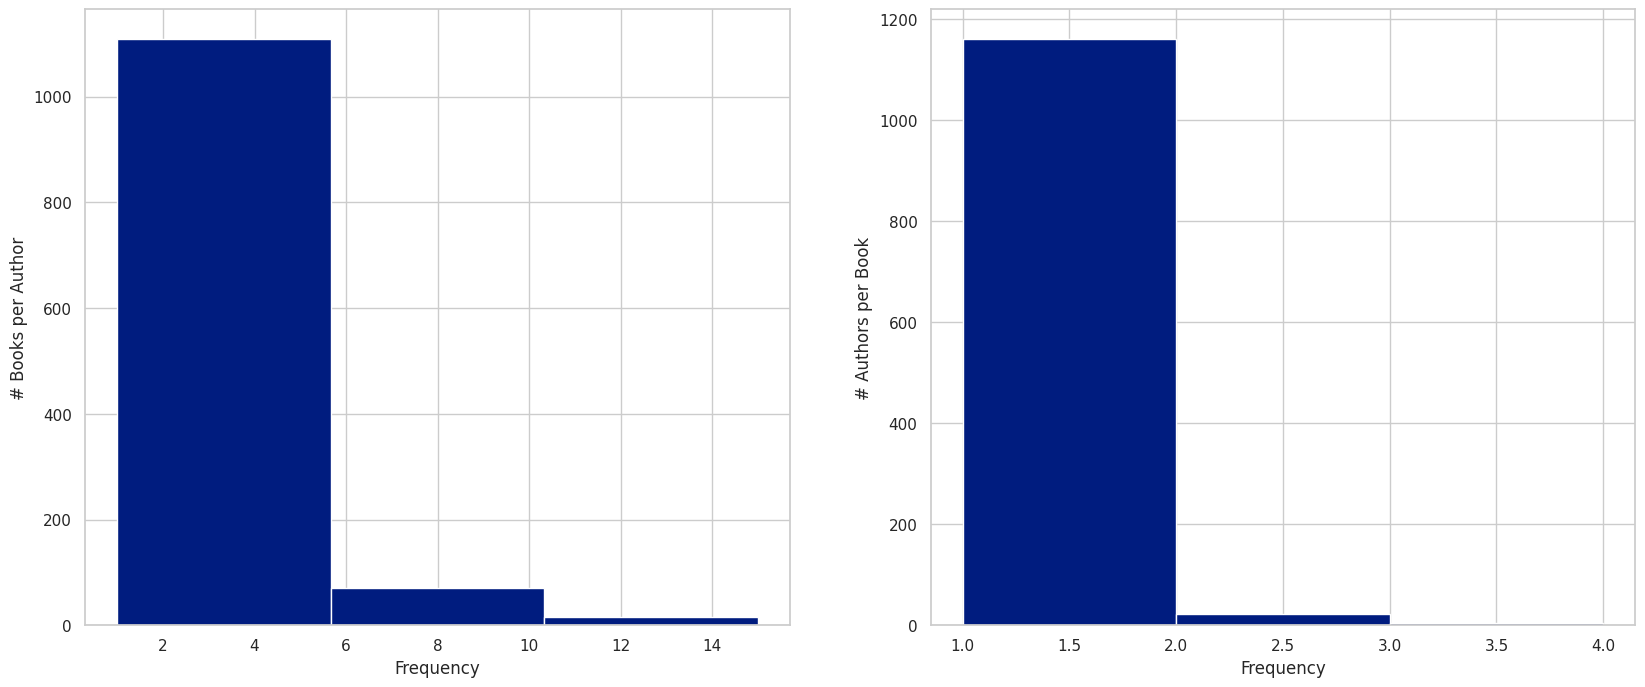

In [11]:
books_per_author = library_df.groupby(['Author']).count()['Books'].reset_index()
library_df = library_df.merge(books_per_author, on='Author', suffixes=['', ' Per Author'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Frequency")
ax2.set_xlabel("Frequency")
ax1.set_ylabel("# Books per Author")
ax2.set_ylabel("# Authors per Book")

library_df['Books Per Author'].hist(ax=ax1, bins=3)
library_df['Author Count'].hist(ax=ax2, bins=3)
plt.show()

In [12]:
library_df.drop(columns=['Date Read', 'Books', 'Author', 'Month Read'], inplace=True)
library_df.head()

,Year Published,Pages,Favorite,Cat_Month Read,Year Read,Decade Read,cos_Month Read,sin_Month Read,Words in Title,Surname Length,Author Count,Books Per Year,Pages Per Year,Books Per Author
0,1781,606,1,Jun,1968.0,1960.0,1.224647e-16,1.224647e-16,2,8,1.0,12,244.916667,8
1,1781,122,0,Jul,1980.0,1980.0,-5.000000e-01,-5.000000e-01,6,8,1.0,12,337.833333,8
2,1781,606,0,May,1983.0,1980.0,5.000000e-01,5.000000e-01,2,8,1.0,36,263.611111,8
3,1762,226,0,Jul,1983.0,1980.0,-5.000000e-01,-5.000000e-01,4,8,1.0,36,263.611111,8
4,1762,226,0,Jul,1983.0,1980.0,-5.000000e-01,-5.000000e-01,10,8,1.0,36,263.611111,8


* I will use RobustScaler for the data as for many of the features, the data skews to to the left. Ex. 'Books Per Author', 'Authors Per Book', 'Pages', etc. 
* 'Month Read' will also be encoded cyclically so the seuqential nature of the month category will be taken into account within the model.
* We have a lot of 'nan' values, instead of removing them, I will use an imputer to fill in values.

## Model Creation & Evaluation

In [13]:
transformer = make_column_transformer(
    (RobustScaler(), ['Pages', 'Pages Per Year', 
                      'Books Per Year', 'Books Per Author', 
                      'Words in Title', 'Surname Length', 'Author Count']),
    (OrdinalEncoder(), ['Year Read', 'Year Published', 'Decade Read']),
    (OneHotEncoder(), ['Cat_Month Read']),
    remainder="passthrough", sparse_threshold=0)

transformed = transformer.fit_transform(library_df)
feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]

transformed_df = pd.DataFrame(transformed, columns=feature_names)
print("Final shape of data:", transformed_df.shape)
print("\nFeatures: \n", transformed_df.columns.values)

Final shape of data: (1196, 25)

Features: 
 ['Pages' 'Pages Per Year' 'Books Per Year' 'Books Per Author'
 'Words in Title' 'Surname Length' 'Author Count' 'Year Read'
 'Year Published' 'Decade Read' 'Cat_Month Read_Apr' 'Cat_Month Read_Aug'
 'Cat_Month Read_Dec' 'Cat_Month Read_Feb' 'Cat_Month Read_Jan'
 'Cat_Month Read_Jul' 'Cat_Month Read_Jun' 'Cat_Month Read_Mar'
 'Cat_Month Read_May' 'Cat_Month Read_Nov' 'Cat_Month Read_Oct'
 'Cat_Month Read_Sep' 'Favorite' 'cos_Month Read' 'sin_Month Read']


In [14]:
# Imputing missing values for 'Month Read', 'Year Published', 'Various'
imputer = SimpleImputer(missing_values=np.nan)
transformed_df = pd.DataFrame(imputer.fit_transform(transformed_df), columns=transformed_df.columns)

x = transformed_df.drop(columns=['Favorite'])
y = transformed_df['Favorite'].astype('int')
x.head()

,Pages,Pages Per Year,Books Per Year,Books Per Author,Words in Title,Surname Length,Author Count,Year Read,Year Published,Decade Read,...,Cat_Month Read_Jan,Cat_Month Read_Jul,Cat_Month Read_Jun,Cat_Month Read_Mar,Cat_Month Read_May,Cat_Month Read_Nov,Cat_Month Read_Oct,Cat_Month Read_Sep,cos_Month Read,sin_Month Read
0,1.601918,-0.988794,-1.214286,3.5,-0.333333,0.666667,0.0,0.0,70.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,1.224647e-16
1,-0.719424,0.485801,-1.214286,3.5,1.000000,0.666667,0.0,12.0,70.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.000000e-01,-5.000000e-01
2,1.601918,-0.692112,0.500000,3.5,-0.333333,0.666667,0.0,15.0,70.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.000000e-01,5.000000e-01
3,-0.220624,-0.692112,0.500000,3.5,0.333333,0.666667,0.0,15.0,61.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.000000e-01,-5.000000e-01
4,-0.220624,-0.692112,0.500000,3.5,2.333333,0.666667,0.0,15.0,61.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.000000e-01,-5.000000e-01


Since our classes are imbalanced, accuracy may not be the best performance metric. So, instead, we will be using the ROC AUC score as our evaluation metric, which allows us to produce more reliable results for an imbalanced dataset such as this. 

Additionally, I will try manual over and undersampling combinations on the original data in an attempt to further optimize the initial ROC AUC score:
* 1st prediction: No over or undersampling
* 2nd prediction: RandomOverSampling followed by RandomUnderSampling
* 3rd prediction: SMOTE followed by RandomUnderSampling

In [15]:
def fit_evaluate_clf(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, stratify=y, random_state=0)
    print("x_train shape: " + str(x_train.shape))
    print("x_test shape: " + str(x_test.shape))

    clf = LogisticRegressionCV(class_weight='balanced', 
                               scoring='roc_auc_ovr_weighted', Cs=100, random_state=0)
    clf.fit(x_train,y_train)

    y_pred = clf.predict(x_test)
    score = clf.score(x_test, y_test)
    print("ROC AUC score: ", score)
    print("\nClassification Report\n",classification_report(y_test, y_pred))
    print("Confusion Matrix\n", confusion_matrix(y_test,y_pred))

    coefs = pd.Series(clf.coef_.ravel(), index=clf.feature_names_in_)
    coefs.sort_values().plot(kind='barh')

    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.show()
    
    return score

Sampling strategy:  x_y
x_train shape: (897, 24)
x_test shape: (299, 24)
ROC AUC score:  0.6874003189792663

Classification Report
               precision    recall  f1-score   support

           0       0.93      0.70      0.80       266
           1       0.19      0.58      0.29        33

    accuracy                           0.69       299
   macro avg       0.56      0.64      0.54       299
weighted avg       0.85      0.69      0.74       299

Confusion Matrix
 [[186  80]
 [ 14  19]]


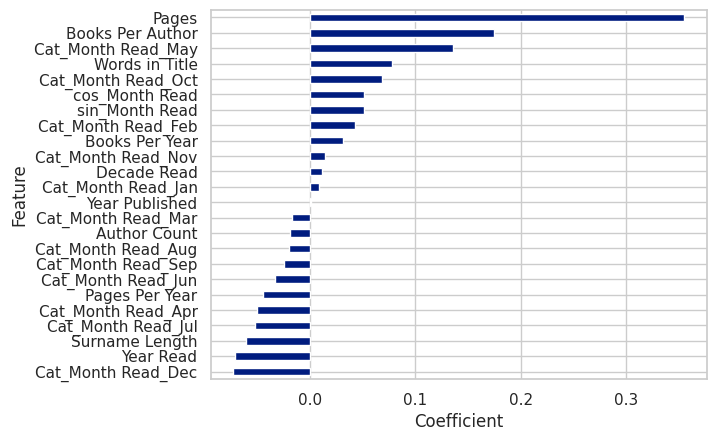

Sampling strategy:  over_under
x_train shape: (1596, 24)
x_test shape: (532, 24)
ROC AUC score:  0.7312878059811182

Classification Report
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       266
           1       0.67      0.64      0.66       266

    accuracy                           0.67       532
   macro avg       0.67      0.67      0.67       532
weighted avg       0.67      0.67      0.67       532

Confusion Matrix
 [[183  83]
 [ 95 171]]


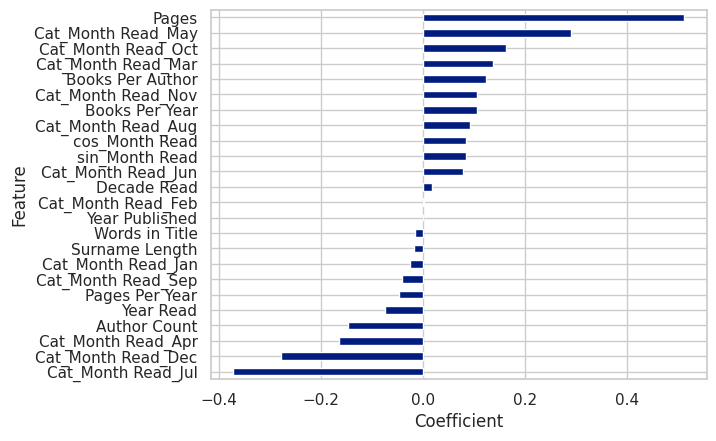

Sampling strategy:  SMOTE_under
x_train shape: (1596, 24)
x_test shape: (532, 24)
ROC AUC score:  0.7498445361524111

Classification Report
               precision    recall  f1-score   support

           0       0.68      0.65      0.67       266
           1       0.67      0.69      0.68       266

    accuracy                           0.67       532
   macro avg       0.67      0.67      0.67       532
weighted avg       0.67      0.67      0.67       532

Confusion Matrix
 [[174  92]
 [ 83 183]]


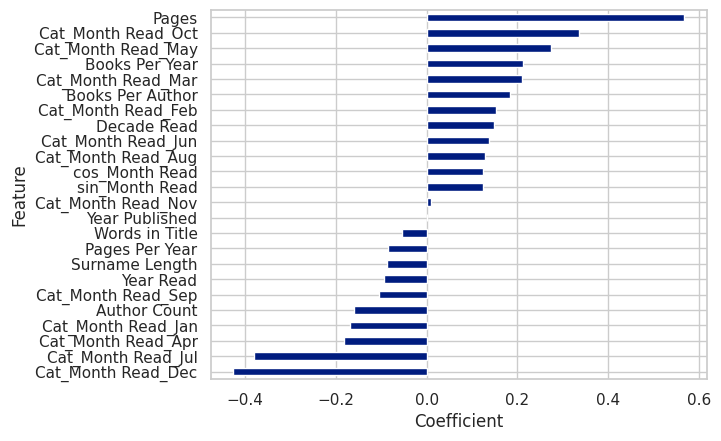

In [16]:
scores = list()

# fit and apply the undersampler+oversampler transform
X_over, y_over = RandomOverSampler().fit_resample(x, y)
X_over_under, y_over_under = RandomUnderSampler().fit_resample(X_over, y_over)

# fit and apply the undersampler+SMOTE transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(x, y)
X_SMOTE_under, y_SMOTE_under = RandomUnderSampler().fit_resample(X_SMOTE, y_SMOTE)

sampling_strategies = { 'x_y': [x, y],
                        'over_under': [X_over_under, y_over_under],
                        'SMOTE_under': [X_SMOTE_under, y_SMOTE_under]}

for strategy in sampling_strategies.keys():
    print("Sampling strategy: ", strategy)
    x, y = sampling_strategies[strategy]
    scores.append(fit_evaluate_clf(x, y))

In [17]:
best_strategy_idx = scores.index(max(scores))

print("Mean ROC AUC scoring: ", np.mean(scores))
print("\nBest scoring sampling strategy: ", list(sampling_strategies.keys())[best_strategy_idx])
print("Best ROC AUC score: ", scores[best_strategy_idx])

Mean ROC AUC scoring:  0.7228442203709319

Best scoring sampling strategy:  SMOTE_under
Best ROC AUC score:  0.7498445361524111
